In [2]:
import cv2
import numpy as np
import os
import time
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from models.network_swinir import SwinIR
from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


# Creating Panorama of the Images

In [ ]:
class ImageStitcher:
    def __init__(self, image_folder, target_width=800, max_dimension=32000):
        self.image_folder = image_folder
        self.target_width = target_width
        self.max_dimension = max_dimension  # Maximum allowed dimension
        self.images = []
        self.load_images()

    def load_images(self):
        """Load and resize images to consistent dimensions"""
        extensions = ['.bmp', '.jpg', '.png', '.tif']
        for filename in sorted(os.listdir(self.image_folder)):
            if os.path.splitext(filename)[1].lower() in extensions:
                img = cv2.imread(os.path.join(self.image_folder, filename))
                if img is not None:
                    aspect_ratio = img.shape[1] / img.shape[0]
                    target_height = int(self.target_width / aspect_ratio)
                    img = cv2.resize(img, (self.target_width, target_height))
                    img = cv2.convertScaleAbs(img, alpha=1.2, beta=0)
                    self.images.append(img)
        return self.images

    def scale_panorama(self, panorama, max_dim=None):
        """Scale panorama if it exceeds maximum dimensions"""
        if max_dim is None:
            max_dim = self.max_dimension

        height, width = panorama.shape[:2]
        if width > max_dim or height > max_dim:
            scale = min(max_dim / width, max_dim / height)
            new_width = int(width * scale)
            new_height = int(height * scale)
            return cv2.resize(panorama, (new_width, new_height))
        return panorama

    def enhance_features(self, img):
        """Enhance image features for better matching"""
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        enhanced = cv2.GaussianBlur(enhanced, (3,3), 0)
        return enhanced

    def match_features(self, img1, img2, debug=False):
        """Match features using both ORB and FLANN approaches"""
        img1_enhanced = self.enhance_features(img1)
        img2_enhanced = self.enhance_features(img2)

        orb = cv2.ORB_create(
            nfeatures=10000,
            scaleFactor=1.2,
            nlevels=8,
            edgeThreshold=31,
            firstLevel=0,
            WTA_K=2,
            patchSize=31,
            fastThreshold=20
        )

        kp1, des1 = orb.detectAndCompute(img1_enhanced, None)
        kp2, des2 = orb.detectAndCompute(img2_enhanced, None)

        if debug:
            print(f"ORB Keypoints found: {len(kp1)} in img1, {len(kp2)} in img2")

        if des1 is None or des2 is None or len(kp1) < 10 or len(kp2) < 10:
            if debug:
                print("Insufficient keypoints")
            return None, None, None

        # Use BruteForce matching for more reliable results
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        matches = bf.knnMatch(des1, des2, k=2)

        good_matches = []
        for pair in matches:
            if len(pair) == 2:
                m, n = pair
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

        if debug:
            print(f"Good matches found: {len(good_matches)}")

        if len(good_matches) < 8:
            if debug:
                print("Insufficient good matches")
            return None, None, None

        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        return src_pts, dst_pts, good_matches

    def stitch_images_sequential(self):
        """Stitch images sequentially with improved size management"""
        if not self.images:
            return None

        start_time = time.time()
        print(f"Total images to process: {len(self.images)}")
        result = self.images[0]

        # Track panorama size
        total_width = result.shape[1]
        max_height = result.shape[0]

        for i in range(1, len(self.images)):
            print(f"\nProcessing image {i}/{len(self.images)-1}")

            # Check if current panorama needs scaling
            if total_width > self.max_dimension * 0.8 or max_height > self.max_dimension * 0.8:
                print("Scaling down panorama to prevent size issues...")
                result = self.scale_panorama(result, self.max_dimension * 0.8)
                total_width = result.shape[1]
                max_height = result.shape[0]

            current_img = self.images[i]
            src_pts, dst_pts, matches = self.match_features(result, current_img, debug=True)

            if src_pts is None:
                print(f"Retrying image {i} with adjusted parameters...")
                if i < len(self.images) - 1:
                    src_pts, dst_pts, matches = self.match_features(current_img, self.images[i+1], debug=True)
                    if src_pts is not None:
                        result = current_img
                        total_width = result.shape[1]
                        max_height = max(max_height, result.shape[0])
                        continue
                print(f"Skipping image {i} - could not find matches")
                continue

            try:
                # Find homography
                H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                if H is None:
                    print(f"Skipping image {i} - invalid homography")
                    continue

                # Calculate new dimensions
                h1, w1 = result.shape[:2]
                h2, w2 = current_img.shape[:2]
                corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
                warped_corners = cv2.perspectiveTransform(corners, H)

                [x_min, y_min] = np.int32(warped_corners.min(axis=0).ravel())
                [x_max, y_max] = np.int32(warped_corners.max(axis=0).ravel())

                x_min = min(x_min, 0)
                y_min = min(y_min, 0)

                w_pano = max(x_max, w2) - x_min
                h_pano = max(y_max, h2) - y_min

                # Check if dimensions exceed limits
                if w_pano > self.max_dimension or h_pano > self.max_dimension:
                    scale = min(self.max_dimension / w_pano, self.max_dimension / h_pano) * 0.95  # 5% margin
                    w_pano = int(w_pano * scale)
                    h_pano = int(h_pano * scale)

                    # Scale the current result and image
                    result = cv2.resize(result, None, fx=scale, fy=scale)
                    current_img = cv2.resize(current_img, None, fx=scale, fy=scale)

                    # Recalculate homography with scaled points
                    src_pts *= scale
                    dst_pts *= scale
                    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Create translation matrix
                translation = np.array([
                    [1, 0, -x_min],
                    [0, 1, -y_min],
                    [0, 0, 1]
                ])

                H_final = translation.dot(H)
                warped_img = cv2.warpPerspective(result, H_final, (w_pano, h_pano))

                # Update the current image position
                y_offset = max(0, -y_min)
                x_offset = max(0, -x_min)
                y_end = min(y_offset + current_img.shape[0], h_pano)
                x_end = min(x_offset + current_img.shape[1], w_pano)

                if y_end > y_offset and x_end > x_offset:
                    warped_img[y_offset:y_end, x_offset:x_end] = current_img[:y_end-y_offset, :x_end-x_offset]

                result = warped_img
                total_width = result.shape[1]
                max_height = max(max_height, result.shape[0])
                print(f"Successfully stitched image {i}")

            except Exception as e:
                print(f"Error processing image {i}: {str(e)}")
                continue

        end_time = time.time()
        print(f"Total processing time: {end_time - start_time:.2f} seconds")
        return result

def main():
    folder_path = "/content/drive/MyDrive/abc"
    stitcher = ImageStitcher(folder_path, target_width=800, max_dimension=32000)
    panorama = stitcher.stitch_images_sequential()

    if panorama is not None:
        output_path = ("/content/panorama_result.jpg")
        cv2.imwrite(output_path, panorama, [cv2.IMWRITE_JPEG_QUALITY, 90])
        print(f"Panorama saved as: {output_path}")
    else:
        print("Failed to create panorama")

if __name__ == "__main__":
    main()

Total images to process: 159

Processing image 1/158
ORB Keypoints found: 10000 in img1, 10000 in img2
Good matches found: 4647
Successfully stitched image 1

Processing image 2/158
ORB Keypoints found: 10000 in img1, 10000 in img2
Good matches found: 3601
Successfully stitched image 2

Processing image 3/158
ORB Keypoints found: 10000 in img1, 10000 in img2
Good matches found: 2883
Successfully stitched image 3

Processing image 4/158
ORB Keypoints found: 10000 in img1, 10000 in img2
Good matches found: 2063
Successfully stitched image 4

Processing image 5/158
ORB Keypoints found: 10000 in img1, 10000 in img2
Good matches found: 1631
Successfully stitched image 5

Processing image 6/158
ORB Keypoints found: 10000 in img1, 10000 in img2
Good matches found: 1406
Successfully stitched image 6

Processing image 7/158
ORB Keypoints found: 10000 in img1, 10000 in img2
Good matches found: 1123
Successfully stitched image 7

Processing image 8/158
ORB Keypoints found: 10000 in img1, 10000 in

# Removing blacked area from the Image

In [11]:
def crop_with_predefined_rules(image, top_percent=0.008, bottom_percent=0.008, left_percent=0.001, right_percent=0.00):
    """
    Crop the image based on predefined percentages.

    :param image: Input image as a numpy array.
    :param top_percent: Percentage to crop from the top.
    :param bottom_percent: Percentage to crop from the bottom.
    :param left_percent: Percentage to crop from the left.
    :param right_percent: Percentage to crop from the right.
    :return: Cropped image.
    """
    height, width = image.shape[:2]

    # Calculate the cropping dimensions
    top = int(height * top_percent)
    bottom = int(height * bottom_percent)
    left = int(width * left_percent)
    right = int(width * right_percent)

    # Crop the image
    cropped_image = image[top:height-bottom, left:width-right]
    return cropped_image

# Load an example image
image_path = "/content/panorama_results.jpg"  # Replace with your image path
output_path_cropped = "/content/cropped_image.jpg"
image = cv2.imread(image_path)

# Crop the image using predefined rules
cropped_image = crop_with_predefined_rules(image, top_percent=0.1, bottom_percent=0.1, left_percent=0.1, right_percent=0.1)

# Save and display the cropped image
cv2.imwrite(output_path_cropped, cropped_image)
print(f"Cropped image saved to {output_path_cropped}")

Cropped image saved to /content/cropped_image.jpg


# Enhancing the Image

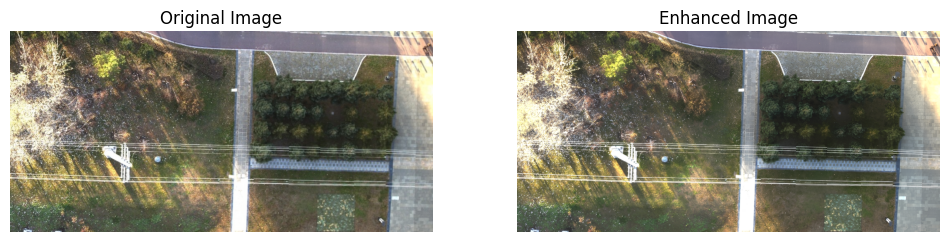

Enhanced image saved to /content/enhanced_image.jpg


In [12]:
# Define the model loading function
def load_pretrained_swinir_model(task="realSR", scale=2, model_path=None):
    """
    Load a pre-trained SwinIR model.

    Args:
        task (str): Task type ("realSR", "classicalSR", "denoise", etc.).
        scale (int): Upscaling factor for super-resolution.
        model_path (str): Path to the pre-trained weights.

    Returns:
        model: SwinIR model with loaded weights.
    """
    # Set model parameters based on the task
    if task == "realSR":
        embed_dim = 180
        depths = [6, 6, 6, 6, 6, 6]
        num_heads = [6, 6, 6, 6, 6, 6]
        window_size = 8
        mlp_ratio = 2
        upsampler = "nearest+conv"  # Recommended upsampler for realSR
    elif task == "classicalSR":
        embed_dim = 96
        depths = [6, 6, 6, 6]
        num_heads = [6, 6, 6, 6]
        window_size = 7
        mlp_ratio = 4
        upsampler = "pixelshuffle"
    elif task == "denoise":
        embed_dim = 64
        depths = [6, 6, 6, 6]
        num_heads = [6, 6, 6, 6]
        window_size = 7
        mlp_ratio = 2
        upsampler = None  # Denoising doesn't require upsampling
    else:
        raise ValueError(f"Unsupported task: {task}")

    # Initialize the SwinIR model
    model = SwinIR(
        upscale=scale,
        img_size=64,
        window_size=window_size,
        in_chans=3,
        img_range=1.0,
        embed_dim=embed_dim,
        depths=depths,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        upsampler=upsampler,
        resi_connection="1conv"
    )

    # Load pre-trained weights
    if model_path:
        state_dict = torch.load(model_path, map_location="cuda")
        if "params" in state_dict:  # Handle nested keys
            state_dict = state_dict["params"]
        elif "params_ema" in state_dict:
            state_dict = state_dict["params_ema"]
        model.load_state_dict(state_dict, strict=True)
    else:
        raise FileNotFoundError("Model path not provided or incorrect.")

    model.eval()  # Set model to evaluation mode
    return model


# Image enhancement function
def enhance_image(image_path, model, device="cuda"):
    """
    Enhance an image using the SwinIR model.

    Args:
        image_path (str): Path to the input image.
        model: SwinIR model instance.
        device (str): Device to use ("cpu" or "cuda").

    Returns:
        tuple: Original and enhanced images.
    """
    device = torch.device(device)
    model = model.to(device)

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    transform = transforms.ToTensor()  # Normalize to [0, 1] range
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Enhance the image
    with torch.no_grad():
        output = model(img_tensor)

    # Post-process and convert back to PIL Image
    output = output.squeeze(0).clamp(0, 1).cpu()
    output_img = transforms.ToPILImage()(output)

    return img, output_img


# Main execution block
def main():
    # Define paths and parameters
    image_path = output_path_cropped  # Replace with your image path
    model_path = "/content/drive/MyDrive/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x2_GAN-with-dict-keys-params-and-params_ema.pth"  # Replace with your model path
    task = "realSR"  # Choose task: "realSR", "classicalSR", "denoise", etc.
    scale = 2  # Scale factor for super-resolution
    output_path = "/content/enhanced_image.jpg"

    # Load the SwinIR model with pre-trained weights
    model = load_pretrained_swinir_model(task=task, scale=scale, model_path=model_path)

    # Enhance the image
    input_img, enhanced_img = enhance_image(image_path, model)

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(input_img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Enhanced Image")
    plt.imshow(enhanced_img)
    plt.axis("off")

    plt.show()

    output_path = "/content/enhanced_image.jpg"
    enhanced_img.save(output_path)
    print(f"Enhanced image saved to {output_path}")


if __name__ == "__main__":
    main()